In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_T=pd.read_csv('C://Users//antoi//Dropbox//PC//Desktop//Projet 5//data_T.csv')


In [88]:
list_of_all_tags = []
for item in data_T['tags']:
    list_of_all_tags.append(item)

tags=np.unique(list_of_all_tags)

In [89]:
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging


logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [90]:
l_cat = tags.tolist()
print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(data_T['tags'][i])) for i in range(len(data_T))]

catégories :  ['.net', 'android', 'c', 'cocoa', 'com', 'cplusplus', 'file', 'html', 'http', 'int', 'ios', 'iphone', 'java', 'jquery', 'linux', 'object', 'orm', 'other', 'php', 'python', 'ram', 'ruby', 'spring', 'sql', 'string', 'view', 'visual-studio', 'window', 'xcode']


# Traitement


## Bag of word - Tf-idf

### Préparation sentences

In [91]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'keywords_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])
ctf_transform = ctf.transform(data_T[feat])

In [92]:
df_bowcv=pd.DataFrame(cv_transform.toarray(),columns=cvect.get_feature_names())
df_bowcv

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,amp,android,app,application,array,bar,cache,class,code,color,...,string,test,text,time,user,value,version,view,way,web
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4997,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
df_bowctf=pd.DataFrame(ctf_transform.toarray(),columns=ctf.get_feature_names())
df_bowctf

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,amp,android,app,application,array,bar,cache,class,code,color,...,string,test,text,time,user,value,version,view,way,web
0,0.427883,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.232935,0.166746,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.412803,0.000000,0.0,0.268058,0.0
1,0.000000,0.0,0.000000,0.420831,0.0,0.0,0.000000,0.209287,0.149818,0.0,...,0.000000,0.0,0.0,0.000000,0.48144,0.000000,0.000000,0.0,0.240845,0.0
2,0.431650,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.168214,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.270417,0.0
3,0.000000,0.0,0.225075,0.000000,0.0,0.0,0.000000,0.000000,0.120828,0.0,...,0.000000,0.0,0.0,0.312018,0.00000,0.000000,0.000000,0.0,0.194241,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.234809,0.168088,0.0,...,0.336907,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.234809,0.168088,0.0,...,0.336907,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0
4996,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.470245,0.167905,0.120194,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.470245,0.0,0.000000,0.0
4997,0.000000,0.0,0.309367,0.000000,0.0,0.0,0.000000,0.232003,0.166079,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0
4998,0.000000,0.0,0.309367,0.000000,0.0,0.0,0.000000,0.232003,0.166079,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0


Fonctions pour réaliser l'ACP

In [94]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

ACP pour le bag of words CountVectorizer

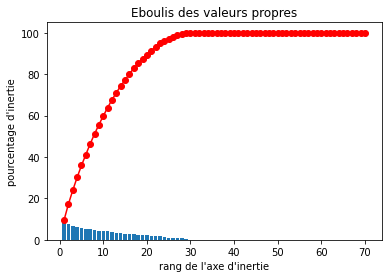

In [95]:
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer


# préparation des données pour l'ACP
X = df_bowcv.values
features = df_bowcv.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaledcv = std_scale.transform(X)

# Calcul des composantes principales
pcacv = decomposition.PCA()
pcacv.fit_transform(X_scaledcv)

# Eboulis des valeurs propres
display_scree_plot(pcacv)

plt.show()

ACP pour le bag of words Tf-idf

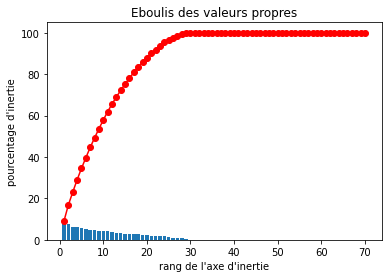

In [96]:
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer


# préparation des données pour l'ACP
X = df_bowctf.values
features = df_bowctf.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaledctf = std_scale.transform(X)

# Calcul des composantes principales
pcactf = decomposition.PCA()
pcactf.fit_transform(X_scaledctf)

# Eboulis des valeurs propres
display_scree_plot(pcactf)

plt.show()



## Word2Vec

In [97]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

### Création du modèle Word2Vec

In [98]:
w2v_size=500
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 100 # adapt to length of sentences
sentences = data_T['keywords_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [99]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 73
Word2Vec trained


In [100]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 74


### Création de la matrice d'embedding

In [101]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 500
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (74, 500)


### Creation du modèle Word2Vec

In [102]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 500)          37000     
                                                                 
 global_average_pooling1d_3   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 37,000
Trainable params: 37,000
Non-trainable params: 0
_________________________________________________________________


In [103]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

157/157 [==============================] - 0s 2ms/step


(5000, 500)

## BERT

In [104]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
from transformers import TFAutoModel, AutoTokenizer


In [105]:
print(tf.__version__)
print(tensorflow.__version__)
print(tf.test.gpu_device_name())
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0

False


### Fonctions communes

In [106]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2,'s')

    return features_bert, last_hidden_states_tot

### BERT HuggingFace

#### 'bert-base-uncased'

In [107]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['keywords_dl'].to_list()

In [108]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 528ms/step
temps traitement :  331.0 s


In [109]:
features_bert.shape



(5000, 768)

## USE - Universal Sentence Encoder

In [110]:
import tensorflow_hub as hub


embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [111]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2,'s')
    return features

In [112]:
batch_size = 10
sentences = data_T['keywords_dl'].to_list()

In [113]:
features_USE = feature_USE_fct(sentences, batch_size)

temps traitement :  2.0 s


## Fonctions de tests

In [114]:
import pickle
import time
from sklearn import cluster
from sklearn.metrics import jaccard_score
from sklearn import manifold, decomposition
import logging
import time
import sklearn.naive_bayes
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Calcul Tsne, détermination des clusters et calcul Jaccard entre vrais catégorie et n° de clusters


def Jaccard_fct_bayes(features) :
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    # Détermination des clusters à partir des données après Tsne
    cls = sklearn.naive_bayes.BernoulliNB()
    cls.fit(x_train,y_train)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,cls.predict(x_test),average='weighted'),4)
    time2 = np.round(time.time() - time1,0)
    print("Jaccard : ", Jaccard, "time : ", time2)

    return Jaccard, X_tsne, cls.classes_, cls

def Jaccard_fct_LogReg(features) :
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    # Détermination des clusters à partir des données après Tsne
    cls = sklearn.linear_model.LogisticRegression()
    cls.fit(x_train,y_train)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,cls.predict(x_test),average='weighted'),4)
    print(cls.predict(x_test))
    time2 = np.round(time.time() - time1,0)
    print("Jaccard : ", Jaccard, "time : ", time2)

    return Jaccard, X_tsne, cls.classes_, cls


def Jaccard_fct_OvR(features) :
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    # Détermination des clusters à partir des données après Tsne
    cls = sklearn.multiclass.OneVsRestClassifier(SVC())
    cls.fit(x_train,y_train)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,cls.predict(x_test),average='weighted'),4)
    print(cls.predict(x_test))
    time2 = np.round(time.time() - time1,0)
    print("Jaccard : ", Jaccard, "time : ", time2)

    return Jaccard, X_tsne, cls.classes_, cls

def Jaccard_fct_Forest(features) :
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    # Détermination des clusters à partir des données après Tsne
    cls = sklearn.ensemble.RandomForestClassifier()
    cls.fit(x_train,y_train)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,cls.predict(x_test),average='weighted'),4)
    print(cls.predict(x_test))
    time2 = np.round(time.time() - time1,0)
    print("Jaccard : ", Jaccard, "time : ", time2)

    return Jaccard, X_tsne, cls.classes_, cls


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, Jaccard) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tags par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tags par clusters')

    plt.show()
    print("Jaccard : ", Jaccard)


def ScoreFunction(ListFeatures=[X_scaledcv,X_scaledctf,embeddings,features_bert,features_USE],ListFunctions=[Jaccard_fct_bayes,Jaccard_fct_LogReg,Jaccard_fct_OvR,Jaccard_fct_Forest]):
    score=pd.DataFrame(columns=['CountVectorized','Tf-idf','Word2Vec','BERT','USE'],index=['NaiveBayes','LogisticRegression','OneVsRest','RandomForest'])
    models=pd.DataFrame(columns=['CountVectorized','Tf-idf','Word2Vec','BERT','USE'],index=['NaiveBayes','LogisticRegression','OneVsRest','RandomForest'])
    for i in range(len(ListFeatures)):
        for k in range(len(ListFunctions)):
            score.iloc[k,i],tsne,labels,models.iloc[k,i]=ListFunctions[k](ListFeatures[i])
    return score, models

In [115]:
Score,Models=ScoreFunction()

Jaccard :  6.93 time :  21.0


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['other' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  6.3100000000000005 time :  20.0
['ruby' 'ruby' 'sql' ... 'linux' 'cocoa' 'com']
Jaccard :  4.760000000000001 time :  23.0
['other' 'other' 'other' ... 'other' 'other' 'android']
Jaccard :  8.540000000000001 time :  20.0
Jaccard :  6.510000000000001 time :  19.0


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['other' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  6.890000000000001 time :  19.0
['jquery' 'file' 'visual-studio' ... 'python' 'string' 'other']
Jaccard :  3.4000000000000004 time :  23.0
['other' 'other' 'java' ... 'other' 'other' 'other']
Jaccard :  6.3 time :  20.0
Jaccard :  6.47 time :  21.0


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['other' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  6.510000000000001 time :  20.0
['object' 'java' 'linux' ... 'cplusplus' 'object' 'python']
Jaccard :  4.41 time :  23.0
['iphone' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  9.35 time :  20.0
Jaccard :  6.510000000000001 time :  20.0


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['other' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  7.140000000000001 time :  20.0
['cplusplus' 'iphone' 'ios' ... 'file' 'php' 'android']
Jaccard :  3.25 time :  23.0
['other' 'other' 'other' ... 'iphone' 'other' 'cplusplus']
Jaccard :  8.4 time :  21.0
Jaccard :  7.049999999999999 time :  21.0


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['other' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  6.890000000000001 time :  21.0
['cocoa' 'visual-studio' 'other' ... 'iphone' 'android' 'python']
Jaccard :  4.36 time :  24.0
['c' 'php' 'cplusplus' ... 'ruby' 'other' 'other']
Jaccard :  9.07 time :  21.0


In [116]:
Models

,CountVectorized,Tf-idf,Word2Vec,BERT,USE
NaiveBayes,BernoulliNB(),BernoulliNB(),BernoulliNB(),BernoulliNB(),BernoulliNB()
LogisticRegression,LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression()
OneVsRest,OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=SVC()),OneVsRestClassifier(estimator=SVC())
RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...","(DecisionTreeClassifier(max_features='sqrt', r...","(DecisionTreeClassifier(max_features='sqrt', r...","(DecisionTreeClassifier(max_features='sqrt', r...","(DecisionTreeClassifier(max_features='sqrt', r..."


Préparation des modèles pré-établis à partir des features

In [117]:
Jaccard, X_tsne, labels, clsBayes = Jaccard_fct_bayes(features_USE)
Jaccard, X_tsne, labels, clsReg = Jaccard_fct_LogReg(features_USE)
Jaccard, X_tsne, labels, clsOvR = Jaccard_fct_OvR(features_USE)
Jaccard, X_tsne, labels, clsForest = Jaccard_fct_Forest(features_USE)


Jaccard :  6.510000000000001 time :  20.0


C:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['other' 'other' 'other' ... 'other' 'other' 'other']
Jaccard :  7.23 time :  20.0
['string' 'android' 'android' ... 'other' 'sql' 'java']
Jaccard :  4.63 time :  23.0
['c' 'other' 'other' ... 'other' 'other' 'cplusplus']
Jaccard :  7.449999999999999 time :  21.0


# Traitement


## Bag of word - Tf-idf

### Préparation sentences

In [118]:
data_T.dropna(axis=0,inplace=True)

In [119]:
data_T.shape

(4999, 14)

In [120]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])
ctf_transform = ctf.transform(data_T[feat])

In [121]:
df_bowcv=pd.DataFrame(cv_transform.toarray(),columns=cvect.get_feature_names())
df_bowcv

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000014,000015,000016,000017,000018,000019,000020,000021,000022,...,zysek,äpfel,åäö,ømq,привет,ברי,צקלה,السلام,عليكم,दय
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
df_bowctf=pd.DataFrame(ctf_transform.toarray(),columns=ctf.get_feature_names())
df_bowctf

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000014,000015,000016,000017,000018,000019,000020,000021,000022,...,zysek,äpfel,åäö,ømq,привет,ברי,צקלה,السلام,عليكم,दय
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ACP pour le bag of words CountVectorizer

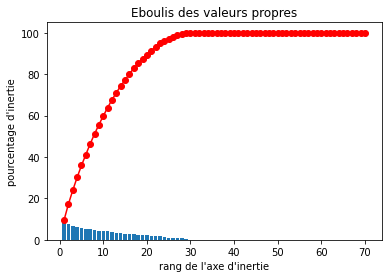

In [123]:
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer


# préparation des données pour l'ACP
X = df_bowcv.values
features = df_bowcv.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaledcv_prep = std_scale.transform(X)

# Calcul des composantes principales
pcacv = decomposition.PCA()
pcacv.fit_transform(X_scaledcv)

# Eboulis des valeurs propres
display_scree_plot(pcacv)

plt.show()

ACP pour le bag of words Tf-idf

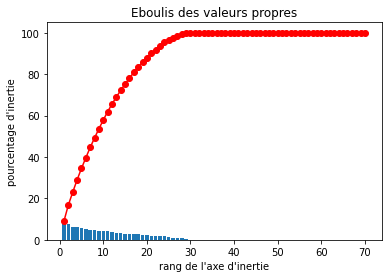

In [124]:
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer


# préparation des données pour l'ACP
X = df_bowctf.values
features = df_bowctf.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaledctf_prep = std_scale.transform(X)

# Calcul des composantes principales
pcactf = decomposition.PCA()
pcactf.fit_transform(X_scaledctf)

# Eboulis des valeurs propres
display_scree_plot(pcactf)

plt.show()



## Word2Vec

In [125]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

### Création du modèle Word2Vec

In [126]:
w2v_size=500
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 100 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [127]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 19323
Word2Vec trained


In [128]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 19324


### Création de la matrice d'embedding

In [129]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 500
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (19324, 500)


### Creation du modèle Word2Vec

In [130]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 100, 500)          9662000   
                                                                 
 global_average_pooling1d_4   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 9,662,000
Trainable params: 9,662,000
Non-trainable params: 0
_________________________________________________________________


In [131]:
embeddings_prep = embed_model.predict(x_sentences)
embeddings.shape

157/157 [==============================] - 0s 2ms/step


(5000, 500)

## BERT

In [132]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
from transformers import TFAutoModel, AutoTokenizer


### Fonctions communes

In [133]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2,'s')

    return features_bert, last_hidden_states_tot

### BERT HuggingFace

#### 'bert-base-uncased'

In [134]:

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

In [135]:
# Création des features

features_bert_prep, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 574ms/step
temps traitement :  363.0 s


In [136]:
features_bert.shape



(5000, 768)

## USE - Universal Sentence Encoder

In [137]:
import tensorflow_hub as hub


embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [138]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2,'s')
    return features

In [139]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [140]:
features_USE_prep = feature_USE_fct(sentences, batch_size)

temps traitement :  3.0 s


Applications aux features généralisées

In [141]:
def JaccardPrepBayes(features):
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,clsBayes.predict(x_test),average='weighted'),4)
    return Jaccard

def JaccardPrepLogReg(features):
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,clsReg.predict(x_test),average='weighted'),4)
    return Jaccard

def JaccardPrepOvR(features):
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,clsOvR.predict(x_test),average='weighted'),4)
    return Jaccard

def JaccardPrepForest(features):
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    minlen=min(X_tsne.shape[0],data_T['tags'].shape[0])
    x_train,x_test,y_train,y_test=train_test_split(X_tsne[:minlen],data_T['tags'].values[:minlen],test_size=0.25)
    Jaccard = 100*np.round(sklearn.metrics.jaccard_score(y_test,clsForest.predict(x_test),average='weighted'),4)
    return Jaccard

def ScoreFunctionPrep(ListFeatures=[X_scaledcv_prep,X_scaledctf_prep,embeddings_prep,features_bert_prep,features_USE_prep],ListFunctions=[JaccardPrepBayes,JaccardPrepLogReg,JaccardPrepOvR,JaccardPrepForest]):
    score=pd.DataFrame(columns=['CountVectorized','Tf-idf','Word2Vec','BERT','USE'],index=['NaiveBayes','LogisticRegression','OneVsRest','RandomForest'])
    for i in range(len(ListFeatures)):
        for k in range(len(ListFunctions)):
            score.iloc[k,i]=(ListFunctions[k])(ListFeatures[i])
    return score

In [ ]:
ScoreUpdated=ScoreFunctionPrep()

In [ ]:
Scores,Models2=ScoreFunction(ListFeatures=[X_scaledcv_prep,X_scaledctf_prep,embeddings_prep,features_bert_prep,features_USE_prep])

In [ ]:
Score

In [ ]:
Score>1/len(tags)

In [ ]:
ScoreUpdated

In [ ]:
ScoreUpdated>1/len(tags)

In [ ]:
Scores

In [ ]:
Scores>1/len(tags)

In [ ]:
features_USE=np.save('features_USE',features_USE)